In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [20]:
import pickle
import gzip

def save_pikle_gzip(obj, file_name):
    """
    history 저장용
    """
    with gzip.open(f'{file_name}.pickle.gz', 'wb') as f:
        pickle.dump(obj, f)

def load_pikle_gzip(file_name):
    """
    history load 테스트용
    """
    with gzip.open(f'{file_name}.pickle.gz','rb') as f:
        load_history = pickle.load(f)
    return load_history

In [2]:
# GPU 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## data load

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [4]:
num_classes = ds_info.features["label"].num_classes
print(num_classes)
print(ds_info.features)

120
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [5]:
# Cutmix 증강

# image a를 바탕으로 b를 추가할때
# a에 추가할 바운딩 박스의 위치를 구하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

# 바탕이미지 a에 b를 바운딩 박스에 추가하여 합성하는 함수
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역

    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# 두 이미지를 합성했기에 라벨도 그에 따라 비율(이미지의 면적)에 따라 변경해주어야함
# ex) a이미지가 전체 이미지대비 0.4 라면 a label의 * 0.4 b label은 *0.6
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 

    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

# cutmix 사용 함수
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [6]:
# Mixup 증강

# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [7]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# num_classes = 120
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False, is_onehot=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    # 테스트가 아니고 일반 aug
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    # 테스트가 아니고 cutmix
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    
    # 테스트가 아니고 mixup
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    
    # test데이터가 cutmix이거나 mixup 일때
    if is_onehot:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )


    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# augmentation이 없는 데이터
ds_train_no_aug = apply_normalize_on_dataset(ds_train)

# 랜덤뒤집기, 밝기 aug적용
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

# cutmix aug
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)

# mixup aug
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

# onehot 적용안한 테스트 데이터
ds_test_no_onehot = apply_normalize_on_dataset(ds_test, is_test=True)

# onehot 적용한 테스트 데이터
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, is_onehot=True)

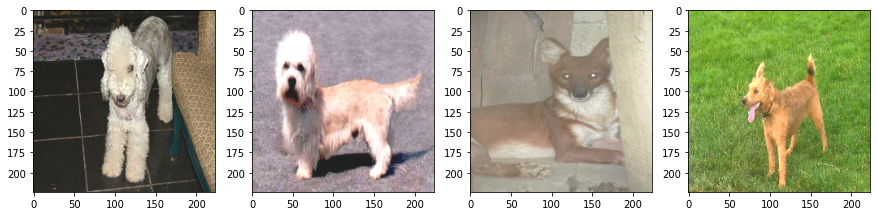

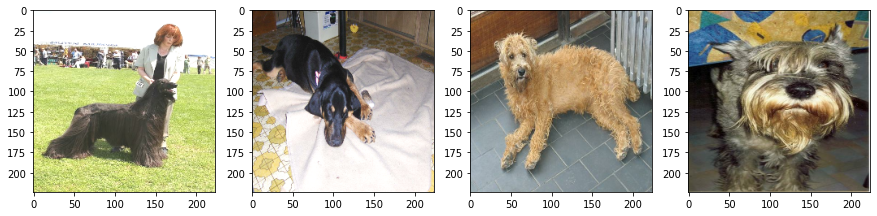

In [9]:
# 랜덤뒤집기, 밝기 aug 적용 확인용
# cutmix aug 확인용
for i, (image, label) in enumerate(ds_train_aug.take(2)):
        
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1,4,1)
    plt.imshow(image[0])
    
    plt.subplot(1,4,2)
    plt.imshow(image[1])
    
    plt.subplot(1,4,3)
    plt.imshow(image[2])
    
    plt.subplot(1,4,4)
    plt.imshow(image[3])

    plt.show()

    if i == 1:
        break

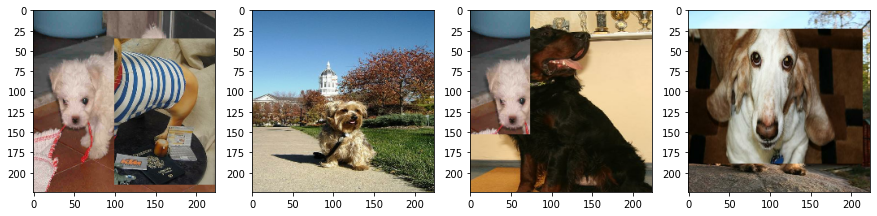

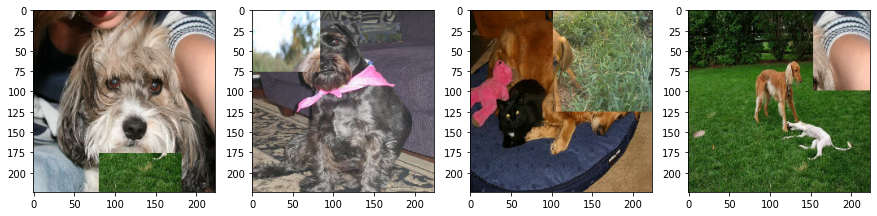

In [10]:
# cutmix aug 확인용
for i, (image, label) in enumerate(ds_train_cutmix.take(2)):
        
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1,4,1)
    plt.imshow(image[0])
    
    plt.subplot(1,4,2)
    plt.imshow(image[1])
    
    plt.subplot(1,4,3)
    plt.imshow(image[2])
    
    plt.subplot(1,4,4)
    plt.imshow(image[3])

    plt.show()

    if i == 1:
        break

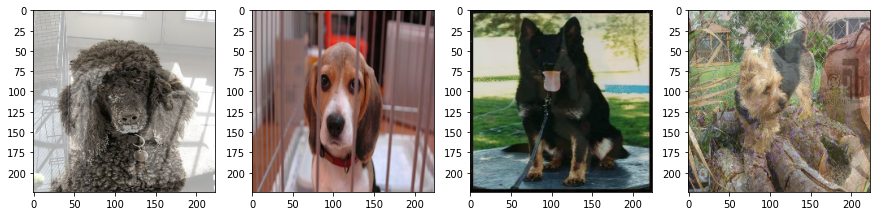

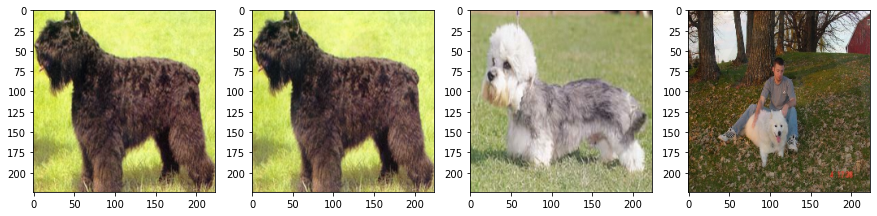

In [11]:
# mixup aug 확인용

for i, (image, label) in enumerate(ds_train_mixup.take(2)):
        
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1,4,1)
    plt.imshow(image[0])
    
    plt.subplot(1,4,2)
    plt.imshow(image[1])
    
    plt.subplot(1,4,3)
    plt.imshow(image[2])
    
    plt.subplot(1,4,4)
    plt.imshow(image[3])

    plt.show()

    if i == 1:
        break

## Model 구성

In [12]:
# no aug 훈련용 model
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# 랜덤뒤집기, 밝기 aug적용한 훈련용 model
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# cutmix aug 적용한 훈련용 model
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# mixup aug 적용한 훈련용 model
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


## Model compile 및 fit

In [13]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

In [14]:
# no aug
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint = keras.callbacks.ModelCheckpoint("resnet50_no_aug.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_onehot,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint],
)

Epoch 1/20
750/750 [==============================] - 198s 199ms/step - loss: 2.1938 - accuracy: 0.4535 - val_loss: 3.1059 - val_accuracy: 0.2559

Epoch 00001: val_accuracy improved from -inf to 0.25595, saving model to resnet50_no_aug.h5
Epoch 2/20
750/750 [==============================] - 151s 201ms/step - loss: 0.6989 - accuracy: 0.8083 - val_loss: 1.0837 - val_accuracy: 0.6828

Epoch 00002: val_accuracy improved from 0.25595 to 0.68284, saving model to resnet50_no_aug.h5
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 0.2125 - accuracy: 0.9554 - val_loss: 1.0568 - val_accuracy: 0.6936

Epoch 00003: val_accuracy improved from 0.68284 to 0.69356, saving model to resnet50_no_aug.h5
Epoch 4/20
750/750 [==============================] - 150s 200ms/step - loss: 0.0657 - accuracy: 0.9937 - val_loss: 0.9253 - val_accuracy: 0.7344

Epoch 00004: val_accuracy improved from 0.69356 to 0.73438, saving model to resnet50_no_aug.h5
Epoch 5/20
750/750 [===============

In [26]:
obj, file_name = history_resnet50_no_aug.history, 'history_resnet50_no_aug'

save_pikle_gzip(obj, file_name)

test = load_pikle_gzip(file_name)
print(test)

{'loss': [2.1938209533691406, 0.6989322304725647, 0.21247848868370056, 0.06566249579191208, 0.027156198397278786, 0.01842803694307804, 0.016609923914074898, 0.010584945790469646, 0.008394073694944382, 0.0073259626515209675, 0.006481517106294632, 0.006222281605005264, 0.005596629343926907, 0.0049082390032708645, 0.004308620933443308, 0.0051163481548428535, 0.0039855316281318665, 0.004247553646564484, 0.003873824141919613, 0.0033832364715635777], 'accuracy': [0.45350000262260437, 0.8083333373069763, 0.9554166793823242, 0.9936666488647461, 0.9987499713897705, 0.9990833401679993, 0.9990833401679993, 0.999750018119812, 0.999833345413208, 0.999750018119812, 0.999833345413208, 0.999666690826416, 1.0, 0.999833345413208, 0.999916672706604, 0.999750018119812, 0.999833345413208, 0.999666690826416, 0.999833345413208, 0.999916672706604], 'val_loss': [3.105940341949463, 1.0836583375930786, 1.0567615032196045, 0.9253124594688416, 0.9375667572021484, 0.9612666964530945, 0.9515060782432556, 0.954627215

In [15]:
# 랜덤뒤집기, 밝기 aug적용한 훈련용 model
resnet50_aug.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint = keras.callbacks.ModelCheckpoint("resnet50_aug.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)


history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # 랜덤 뒤집기, 밝기 augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_onehot,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint],
)

Epoch 1/20
750/750 [==============================] - 159s 201ms/step - loss: 2.2855 - accuracy: 0.4272 - val_loss: 3.3837 - val_accuracy: 0.2172

Epoch 00001: val_accuracy improved from -inf to 0.21723, saving model to resnet50_aug.h5
Epoch 2/20
750/750 [==============================] - 151s 201ms/step - loss: 0.9338 - accuracy: 0.7324 - val_loss: 1.1662 - val_accuracy: 0.6624

Epoch 00002: val_accuracy improved from 0.21723 to 0.66243, saving model to resnet50_aug.h5
Epoch 3/20
750/750 [==============================] - 151s 202ms/step - loss: 0.4965 - accuracy: 0.8649 - val_loss: 1.1449 - val_accuracy: 0.6727

Epoch 00003: val_accuracy improved from 0.66243 to 0.67269, saving model to resnet50_aug.h5
Epoch 4/20
750/750 [==============================] - 151s 201ms/step - loss: 0.2567 - accuracy: 0.9402 - val_loss: 1.0512 - val_accuracy: 0.7011

Epoch 00004: val_accuracy improved from 0.67269 to 0.70114, saving model to resnet50_aug.h5
Epoch 5/20
750/750 [===========================

In [27]:
obj, file_name = history_resnet50_aug.history, 'history_resnet50_aug'

save_pikle_gzip(obj, file_name)

test = load_pikle_gzip(file_name)
print(test)

{'loss': [2.285463571548462, 0.9337846636772156, 0.49650755524635315, 0.25672265887260437, 0.14961284399032593, 0.08130363374948502, 0.05301891639828682, 0.03382580727338791, 0.02226373553276062, 0.020090840756893158, 0.01652384176850319, 0.01345859281718731, 0.010457566007971764, 0.007727140560746193, 0.006502506323158741, 0.007354452274739742, 0.005851030349731445, 0.005922484677284956, 0.004680701065808535, 0.004641553852707148], 'accuracy': [0.4272499978542328, 0.7324166893959045, 0.8649166822433472, 0.9402499794960022, 0.9711666703224182, 0.9879166483879089, 0.9925833344459534, 0.9972500205039978, 0.9986666440963745, 0.9984999895095825, 0.9988333582878113, 0.9989166855812073, 0.9994166493415833, 0.999666690826416, 0.999750018119812, 0.9994999766349792, 0.999750018119812, 0.9995833039283752, 0.999833345413208, 0.999750018119812], 'val_loss': [3.3837332725524902, 1.166194200515747, 1.1448687314987183, 1.0511842966079712, 1.1443264484405518, 0.9336270093917847, 0.9578925967216492, 0.

In [28]:
# cutmix aug 적용한 훈련용 model
resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint = keras.callbacks.ModelCheckpoint("resnet50_cutmix.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint],
)

Epoch 1/20
750/750 [==============================] - 167s 212ms/step - loss: 3.8393 - accuracy: 0.2088 - val_loss: 2.7529 - val_accuracy: 0.3147

Epoch 00001: val_accuracy improved from -inf to 0.31472, saving model to resnet50_cutmix.h5
Epoch 2/20
750/750 [==============================] - 152s 203ms/step - loss: 2.9380 - accuracy: 0.4360 - val_loss: 1.4500 - val_accuracy: 0.5906

Epoch 00002: val_accuracy improved from 0.31472 to 0.59060, saving model to resnet50_cutmix.h5
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 2.6100 - accuracy: 0.5371 - val_loss: 1.4393 - val_accuracy: 0.6002

Epoch 00003: val_accuracy improved from 0.59060 to 0.60016, saving model to resnet50_cutmix.h5
Epoch 4/20
750/750 [==============================] - 153s 203ms/step - loss: 2.3989 - accuracy: 0.6065 - val_loss: 1.2198 - val_accuracy: 0.6663

Epoch 00004: val_accuracy improved from 0.60016 to 0.66628, saving model to resnet50_cutmix.h5
Epoch 5/20
750/750 [===============

In [29]:
obj, file_name = history_resnet50_cutmix.history, 'history_resnet50_cutmix'

save_pikle_gzip(obj, file_name)

test = load_pikle_gzip(file_name)
print(test)

{'loss': [3.8392679691314697, 2.937950849533081, 2.6099534034729004, 2.3989224433898926, 2.248711347579956, 2.121671199798584, 2.0529136657714844, 1.9979585409164429, 1.913874864578247, 1.8470958471298218, 1.794253945350647, 1.7543085813522339, 1.7392672300338745, 1.7054692506790161, 1.6695424318313599, 1.6270180940628052, 1.6253745555877686, 1.5891611576080322, 1.5628961324691772, 1.5604243278503418], 'accuracy': [0.20883333683013916, 0.4359999895095825, 0.5370833277702332, 0.6065000295639038, 0.6552500128746033, 0.7004166841506958, 0.7284166812896729, 0.7402499914169312, 0.7645000219345093, 0.7784166932106018, 0.7927500009536743, 0.799916684627533, 0.8009999990463257, 0.8161666393280029, 0.8219166398048401, 0.8259999752044678, 0.8266666531562805, 0.831166684627533, 0.8390833139419556, 0.8339166641235352], 'val_loss': [2.7528836727142334, 1.4499969482421875, 1.4393420219421387, 1.2198396921157837, 1.2747663259506226, 1.1812770366668701, 1.3786654472351074, 1.199710488319397, 1.2672765

In [30]:
# mixup aug 적용한 훈련용 model
resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint = keras.callbacks.ModelCheckpoint("resnet50_mixup.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)


history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint],
)

Epoch 1/20
750/750 [==============================] - 207s 203ms/step - loss: 3.6963 - accuracy: 0.2428 - val_loss: 3.8673 - val_accuracy: 0.1312

Epoch 00001: val_accuracy improved from -inf to 0.13118, saving model to resnet50_mixup.h5
Epoch 2/20
750/750 [==============================] - 151s 201ms/step - loss: 2.8515 - accuracy: 0.4809 - val_loss: 1.5320 - val_accuracy: 0.5666

Epoch 00002: val_accuracy improved from 0.13118 to 0.56658, saving model to resnet50_mixup.h5
Epoch 3/20
750/750 [==============================] - 151s 202ms/step - loss: 2.6030 - accuracy: 0.5835 - val_loss: 1.3433 - val_accuracy: 0.6196

Epoch 00003: val_accuracy improved from 0.56658 to 0.61964, saving model to resnet50_mixup.h5
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 2.4055 - accuracy: 0.6513 - val_loss: 1.3293 - val_accuracy: 0.6337

Epoch 00004: val_accuracy improved from 0.61964 to 0.63375, saving model to resnet50_mixup.h5
Epoch 5/20
750/750 [===================

In [31]:
obj, file_name = history_resnet50_mixup.history, 'history_resnet50_mixup'

save_pikle_gzip(obj, file_name)

test = load_pikle_gzip(file_name)
print(test)

{'loss': [3.696341037750244, 2.8515231609344482, 2.6029953956604004, 2.4055140018463135, 2.2717342376708984, 2.1488075256347656, 2.0927414894104004, 2.038430690765381, 1.9449492692947388, 1.9241398572921753, 1.8774443864822388, 1.8499635457992554, 1.8391920328140259, 1.8034288883209229, 1.7718242406845093, 1.7631670236587524, 1.7997205257415771, 1.740580439567566, 1.7239363193511963, 1.6852591037750244], 'accuracy': [0.24275000393390656, 0.48091667890548706, 0.5835000276565552, 0.6512500047683716, 0.703083336353302, 0.7473333477973938, 0.7649999856948853, 0.7853333353996277, 0.8136666417121887, 0.8174999952316284, 0.8291666507720947, 0.8365833163261414, 0.8425833582878113, 0.8525000214576721, 0.8574166893959045, 0.8576666712760925, 0.8514166474342346, 0.8607500195503235, 0.8649166822433472, 0.8693333268165588], 'val_loss': [3.8672616481781006, 1.5320268869400024, 1.3433390855789185, 1.3293023109436035, 1.3492000102996826, 1.2405179738998413, 1.1846754550933838, 1.2293387651443481, 1.23

# 훈련결과 시각화

In [60]:
def plot_history(histories, keys):
    plt.figure(figsize=(14, 10))

    # 색상 맵 생성
    unique_keys = list(set(keys))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_keys)))
    color_map = dict(zip(unique_keys, colors))

    # 손실 그래프
    plt.subplot(2, 2, 1)
    for i, key in enumerate(keys):
        color = color_map[key]
        plt.plot(histories[i].history['loss'], label=f'{key} train', color=color, linestyle='-')
        plt.plot(histories[i].history['val_loss'], label=f'{key} val', color=color, linestyle='--')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(2, 2, 2)
    for i, key in enumerate(keys):
        color = color_map[key]
        plt.plot(histories[i].history['accuracy'], label=f'{key} train', color=color, linestyle='-')
        plt.plot(histories[i].history['val_accuracy'], label=f'{key} val', color=color, linestyle='--')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

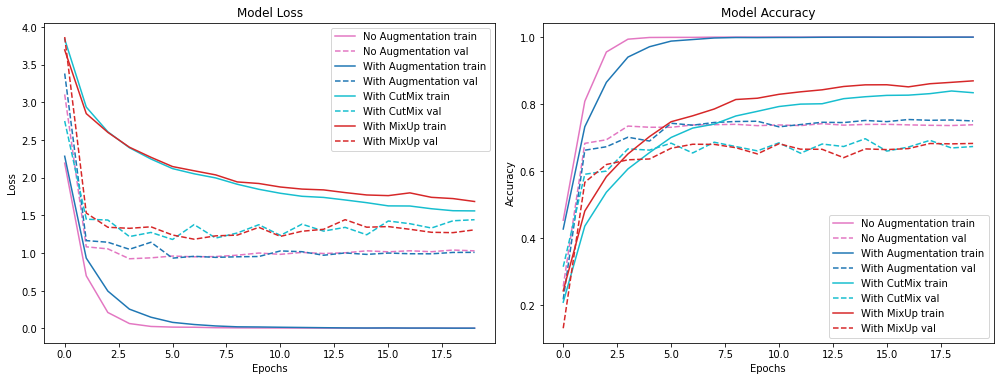

In [61]:
histories = [history_resnet50_no_aug, history_resnet50_aug, history_resnet50_cutmix, history_resnet50_mixup]
keys = ['No Augmentation', 'With Augmentation', 'With CutMix', 'With MixUp']

plot_history(histories, keys)

## 위 그래프 결과 분석
- No Augmentation(Epoch 2.5기준)
    
    train 데이터만 잘맞추게 되는 overfitting일어난거같다.
    - train
        - train accuracy가 무려 1이나 된다
    - validation
        - val accuracy가 0.7 정도에서 더이상 개선이 일어나지 않는다.
- With Augmentation (Epoch 6기준)

    train 데이터만 잘맞추게 되는 overfitting일어난거같다.
    - train
        - train accuracy가 무려 1이나 된다
    - validation
        - val accuracy가 0.9 정도에서 더이상 개선이 일어나지 않는다.
- With Cutmix

    데이터증강을 통해 더 다양한 패턴을 찾고자 증강을 한것인데 너무 복잡하게(?)이미지를 변경하여 정답을 못맞추게되는... 오히려 train만 증가하는 overfitting이 일어난거같다.
    - train
        - train accuracy는 계속 증가한다.
    - validation
        - val accuracy가 들쑥 날쑥이다.. 
- With Mixup

    Cutmix보다는 좀더 val accuracy가 좀더 완만한? 형태로 학습되고 있다는것을 확인할 수 있었다.
    - train
        - 계속 증가
    - validation
        - cutmix와 비교하면 좀더 완만한 형태가 보이며 계속 증가중



In [62]:
def plot_history2(histories, keys):
    plt.figure(figsize=(14, 20))

    for i, key in enumerate(keys):
        # 각 모델에 대한 subplot
        plt.subplot(4, 1, i+1)
        
        # 학습 및 검증 손실
        plt.plot(histories[i].history['loss'], label='Train Loss')
        plt.plot(histories[i].history['val_loss'], label='Val Loss')
        plt.plot(histories[i].history['accuracy'], label='Train Accuracy')
        plt.plot(histories[i].history['val_accuracy'], label='Val Accuracy')
        
        plt.title(f'{key} Loss and Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Loss/Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

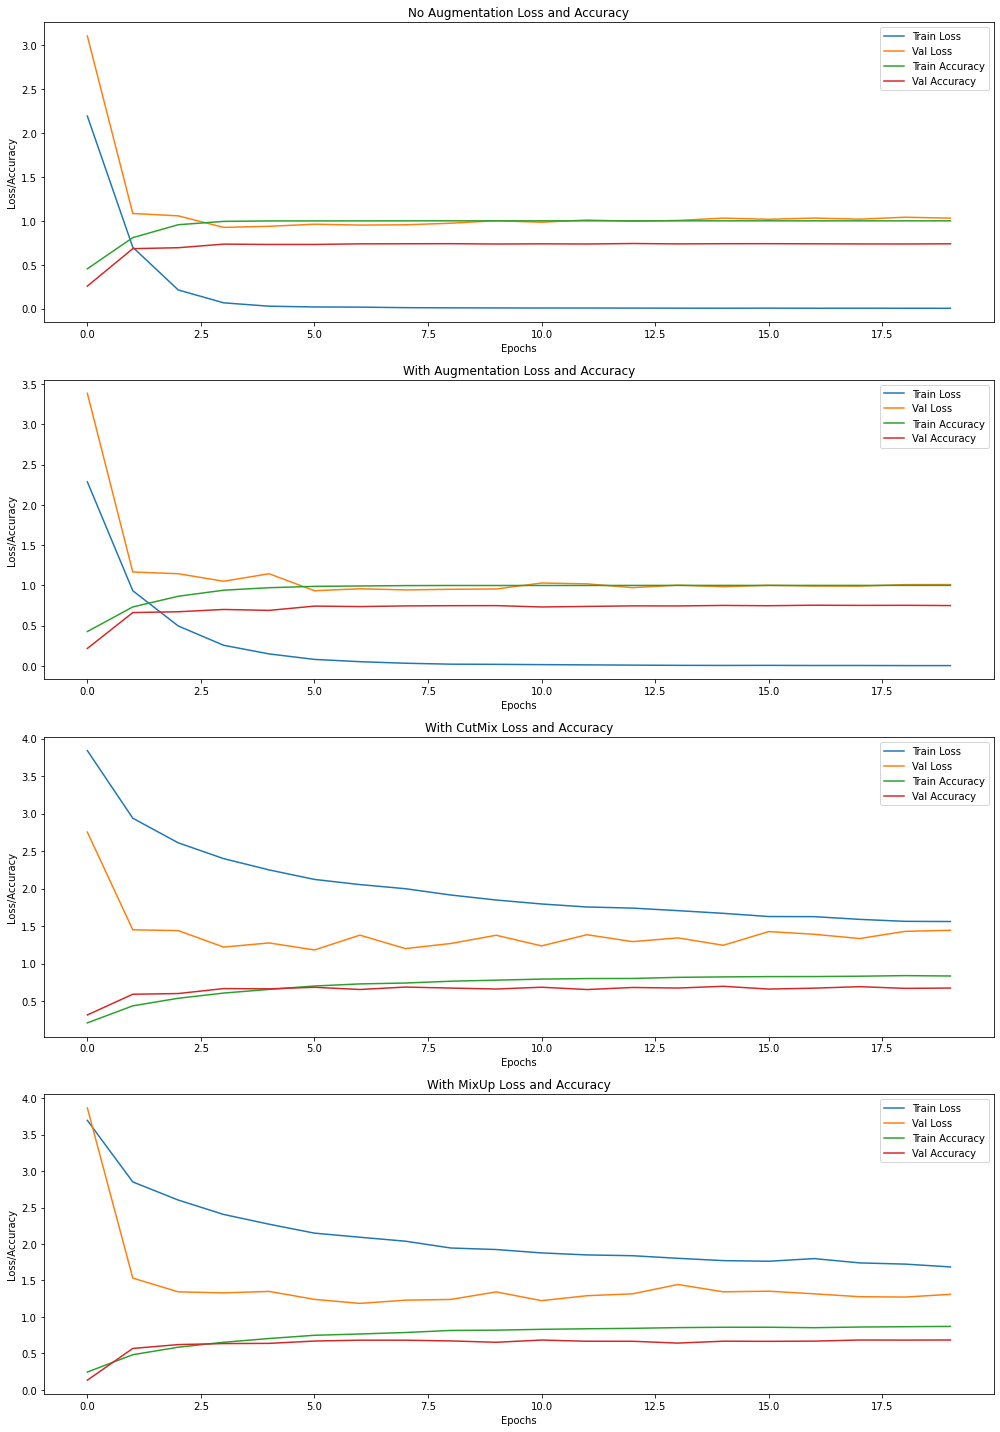

In [63]:
plot_history2(histories, keys)

# 회고
- 배운점
    - 다양한 data augmentation을 구현하는 방법
- 느낀점
    - lms 이슈로 처음에는 colab환경에서 진행했었는데 이때 history 저장하지 않으면서 작업을 진행하다가 colab의 gpu 자원을 다써서 세션이 끊어졌었다. (마지막 epoch 5개만 남았었다) [colab 실험내용](https://github.com/hyeonDD/aiffel/blob/main/18_data_augmentation/quest_colab.ipynb)
    - 위와같은 상황이 일어날때를 대비해 lms환경에서 작업할땐 history 객체를 pickle 및 gzip형태로 저장하면서 진행했다.
    - **실험 결과에 대해 저장을 잘해야겠다라고 느꼈다**
- 아쉬운점
    - 처음부터 history 객체를 저장하지 않아서 colab에서 실행한 4시간이 전부 날아가버렸던 점이 아쉬웠었다.
- 어려웠던점
    - 데이터셋을 적절한 형태로 만드는 함수 apply_normalize_on_dataset을 실행하면 mix_2_labels에서 image_a라는게 없다고 에러가나왔었는데 간단하게 image_a 매개변수를 추가해주면 됐는데 이과정에서 해결하는데 좀 오래걸렸다.